## Load libraries

In [1]:
import pandas as pd
import os,cv2
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import DenseNet121, DenseNet169, DenseNet201
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
print(os.listdir("../input"))

import numpy as np

Using TensorFlow backend.


['test', 'train', 'train.csv', 'sample_submission.csv']


## Read csv data

In [2]:
input_path = '../input/'
train_path = input_path + 'train/train/'
test_path = input_path + 'test/test/'

train_dir="../input/train/train"
test_dir="../input/test/test"
train_df=pd.read_csv('../input/train.csv')

test_df=pd.read_csv('../input/sample_submission.csv')

train_id = train_df['id']
labels = train_df['has_cactus']
test_id = test_df['id']

## Split data into training and validation sets

In [3]:
x_train, x_val, y_train, y_val = train_test_split(train_id, labels, test_size=0.2)

## Load images

In [4]:
def get_images(ids, filepath):
    arr = []
    for img_id in ids:
        img = plt.imread(filepath + img_id)
        arr.append(img)
    
    arr = np.array(arr).astype('float32')
    arr = arr / 255
    return arr

In [5]:
x_train = get_images(ids=x_train, filepath=train_path)
x_val = get_images(ids=x_val, filepath=train_path)
test = get_images(ids=test_id, filepath=test_path)

img_dim = x_train.shape[1:]

## Plot data

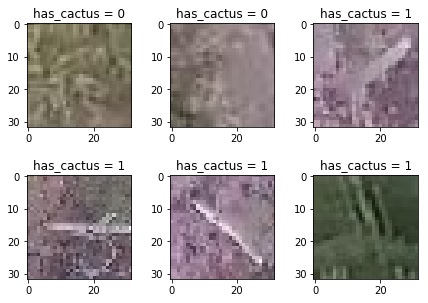

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax = ax.ravel()
plt.tight_layout(pad=0.2, h_pad=2)

for i in range(6):
    ax[i].imshow(x_train[i])
    ax[i].set_title('has_cactus = {}'.format(y_train.iloc[i]))

## Define batch size, epochs and steps

In [8]:
batch_size = 64
epochs = 15
steps = x_train.shape[0] // batch_size

## Define model

In [9]:
inputs = Input(shape=img_dim)

densenet121 = DenseNet121(weights='imagenet', include_top=False)(inputs)

flat1 = Flatten()(densenet121)
dense1 = Dense(units=256, use_bias=True)(flat1)
batchnorm1 = BatchNormalization()(dense1)
act1 = Activation(activation='relu')(batchnorm1)
drop1 = Dropout(rate=0.5)(act1)

out = Dense(units=1, activation='sigmoid')(drop1)

model = Model(inputs=inputs, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.
29089792/29084464 [==============================] - 1s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, mode='max')

img_aug = ImageDataGenerator(rotation_range=20, vertical_flip=True, horizontal_flip=True)
img_aug.fit(x_train)

model.fit_generator(img_aug.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=steps, epochs=epochs, 
                    validation_data=(x_val, y_val), callbacks=[reduce_lr], 
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/15
 - 73s - loss: 0.0807 - val_loss: 0.0419
Epoch 2/15
 - 32s - loss: 0.0350 - val_loss: 0.5405
Epoch 3/15
 - 33s - loss: 0.0337 - val_loss: 0.0257
Epoch 4/15
 - 32s - loss: 0.0217 - val_loss: 0.0468
Epoch 5/15
 - 33s - loss: 0.0185 - val_loss: 0.1507

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/15
 - 32s - loss: 0.0112 - val_loss: 0.0099
Epoch 7/15
 - 32s - loss: 0.0080 - val_loss: 0.0122
Epoch 8/15
 - 33s - loss: 0.0053 - val_loss: 0.0097

Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 9/15
 - 32s - loss: 0.0031 - val_loss: 0.0225
Epoch 10/15
 - 33s - loss: 0.0037 - val_loss: 0.0070
Epoch 11/15
 - 31s - loss: 0.0032 - val_loss: 0.0075

Epoch 00011: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
Epoch 12/15
 - 31s - loss: 0.0033 - val_loss: 0.0099
Epoch 13/15
 - 32s - loss: 0.0020 - val_loss: 0.0090
Epoch 14/15
 - 31s - loss: 0.

## Get predictions

In [12]:
test_pred = model.predict(test, verbose=2)

## Create submission file

In [13]:
test_df['has_cactus'] = test_pred
test_df.to_csv('submission.csv', index=False)